### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results
import scipy.stats as sts
from utils import statistics_first_month,p_val, stat_matrices

In [3]:
#mpl.style.use('seaborn-paper')
font = {'family':'Times New Roman',
        'weight': 'normal',
        'size': 16
        }

axes_font = {'labelsize':20}
mpl.rc('font', **font)
mpl.rc('axes', **axes_font)

In [4]:
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', None)


In [5]:
np.random.seed(seed = 0)

In [6]:

def diff(treated, controls, controls3, pmpm,
         group_name = "",
         check = False, month = 5,
         pf = "", pt = "",  pf2 = ""):
    tr = treated.copy()
    cr = controls.copy()
    controls3 = controls3.copy()
    treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), month), check = False)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
    controls2 = (filter_first_date(findDate(cr.copy(), controls3.copy(), month), check  = False)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
    try:
        controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
    except:
        controls2 = controls2
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
    treated2['Treatment'] = 1
    controls2['Treatment'] = 0
    data2 = [treated2,  controls2]
    for d in data2:
        d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)
    print(treated2.shape, controls2.shape)
    print(treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape)
    print(treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape)
    
    ### see the stats after the drop
    all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))
    columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID',
                         'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB',
                        'Acute6-bin']
    
    all_columns = all_columns +['Acute6-bin']
    
    
    treated2['Acute6-bin'] = (treated2['ACUTE6'] > 0).astype(int)
    controls2['Acute6-bin'] = (controls2['ACUTE6'] > 0).astype(int)

    tr_desc1, treated_first_month = statistics_first_month(treated2.copy(), all_columns, return_array = True, month = month)
    con_desc1, controls_first_month = statistics_first_month(controls2.copy(), all_columns, return_array = True,  month = month)
    conds_first, full_first = stat_matrices(tr_desc1, con_desc1, tr_desc1, con_desc1, columns = columns_to_match)
    conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc1, con_desc1, tr_desc1, con_desc1, columns = all_columns)
    
    times = [0]
    onset = 'ACUTE'
    survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True)#.dropna(axis = 0, subset = ['PERS_ID'])
    
    fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr.copy(), survCo.copy(),
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

    outcome = 'Acute-Care_dd_'+str(group_name)
    #global path_figs, path_figs2, path_tabs
    ylim = [0.7]
    path_figsA = path_figs+pf
    path_figs2A = path_figs2+pf
    path_tabsA = path_tabs+pf
    Path(path_figsA).mkdir(parents = True, exist_ok = True)
    Path(path_figs2A).mkdir(parents = True, exist_ok = True)
    Path(path_tabsA).mkdir(parents = True, exist_ok = True)



    lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr.copy(), survCo.copy(), path_tabs = path_tabsA, 
                                      path_figs=path_figsA,  path_figs2=path_figs2A,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)
    
    statsFM = [conds_first, full_first, conds_firstAllCols, full_firstAllCols]
    return rmstAcuteDD, lrsummDD, statsFM, [survTr, survCo]
    # curves.append((survTr, survCo))

### Load Data

In [7]:
%%time
clusters = 4
sec_id = ""
p = '../tempNNhierAgglo/'
#p1 = 'tempNNhierAgglo2Clust/'
p1 = 'tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)

base_path = '../results/'+p1


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


### Optional(filter registrations after  a particular month and before a particular month)

In [8]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [9]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args={}#{"penalizer":0.001, 'alpha': 0.05}# {}
fit_args = {"step_size": 0.01, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [10]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [11]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

In [12]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


### Acute Care  diff and diff calculation

In [13]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = 
                                                                    ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2 = pd.read_pickle('../Pre_Matching_DATA/'+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 12.3 s, sys: 13.4 s, total: 25.7 s
Wall time: 26 s


In [14]:
import pickle
p3 = '../tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
sv1 = p3+'cg{}{}.p'.format(clusters, sec_id)
sv2 = p3+'tg{}{}.p'.format(clusters, sec_id)

with open(sv1, 'rb') as handle:
    control_groups = pickle.load(handle)

with open(sv2, 'rb') as handle:
    treated_groups = pickle.load(handle)

In [15]:
treated = pd.DataFrame()
controls = pd.DataFrame()

for (g,val),(g2,val2) in zip(treated_groups.items(),control_groups.items()):
    treated = pd.concat((treated, val), ignore_index = True)
    controls = pd.concat((controls, val2), ignore_index = True)

In [16]:
controls.reset_index(drop = True, inplace = True)
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


In [17]:
controls.head(2)

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  \
0  26010351  202001         0               82        104     Medicare   
1  26010351  202002         0               82          1     Medicare   

   ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  ...  IP_BIN6  ER_BIN6  ACUTE6  \
0       0.0       0.0      0.0           0.0  ...      0.0      0.0     0.0   
1       0.0       0.0      0.0           0.0  ...      0.0      0.0     0.0   

   IP_BIN2  ER_BIN2  ACUTE2  HasPast      RD  PERS_ID2  TR-MATCH  
0      0.0      0.0     0.0        1  202001   2601035   2603072  
1      0.0      0.0     0.0        1  202001   2601035   2603072  

[2 rows x 95 columns]

(29143, 101) (138340, 104)
(1364,) (6820,)
(1364,) (6820,)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


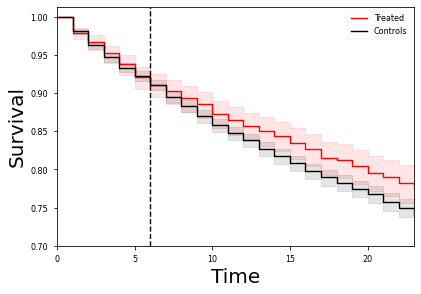

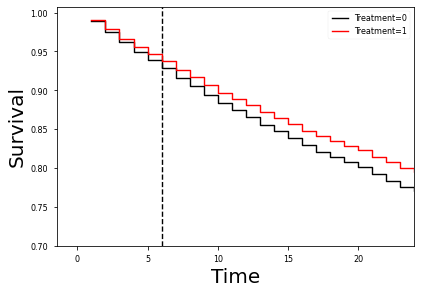

In [18]:
_,_,_,_, = diff(treated.copy(), controls.copy(), controls2, pmpm, group_name = 'ALL',
     check = False, month = 5, pf = 'tot_pop/')

In [19]:
%%capture
%%time

rmsts = {}
lranks = {}
for g in treated_groups:
    if g % 5 == 0:
        print(g)
    r,l,_,_ = diff(treated_groups[g], control_groups[g],controls2, pmpm.copy(), group_name = str(g), pf = 'groups/')
    rmsts[g] = r
    lranks[g] = l

In [20]:
lranks_pd = pd.DataFrame()
for g in lranks:
    lranks_pd = pd.concat((lranks_pd, lranks[g]), axis = 0, ignore_index = True)

In [21]:
lranks_pd

test_statistic         p  -log2(p)
0        0.839456  0.359552  1.475726
1        6.473836  0.010947  6.513268
2        0.142478  0.705830  0.502608
3        2.130914  0.144355  2.792310

In [22]:
rmst_pd = pd.DataFrame(rmsts, index = ['RMST-'+str(i)+'-Months' for i in [6,12,18,24]]).T
rmst_pd.index.name = 'C'
rmst_pd = rmst_pd.reset_index()
rmst_pd

C  RMST-6-Months  RMST-12-Months  RMST-18-Months  RMST-24-Months
0  0       0.040343        0.098130        0.307611        0.484395
1  1      -0.001905        0.119230        0.344607        0.626381
2  2       0.011952        0.012588        0.024650        0.055115
3  3      -0.015663        0.054367        0.151219        0.359005

In [23]:
sizes = [len(treated_groups[c].PERS_ID.unique()) for c in treated_groups]
rmst_pd['Size'] = np.array(sizes)
rmst_pd['Weight'] = rmst_pd['Size']/rmst_pd['Size'].sum()
rmst_pd

C  RMST-6-Months  RMST-12-Months  RMST-18-Months  RMST-24-Months  Size  \
0  0       0.040343        0.098130        0.307611        0.484395   466   
1  1      -0.001905        0.119230        0.344607        0.626381   315   
2  2       0.011952        0.012588        0.024650        0.055115   251   
3  3      -0.015663        0.054367        0.151219        0.359005   332   

     Weight  
0  0.341642  
1  0.230938  
2  0.184018  
3  0.243402

In [24]:
lr_rms = pd.concat((lranks_pd, rmst_pd), axis = 1)
lr_rms.to_csv(path_tabs+'groups/Acute-Care_ddlrank_rmst.csv')

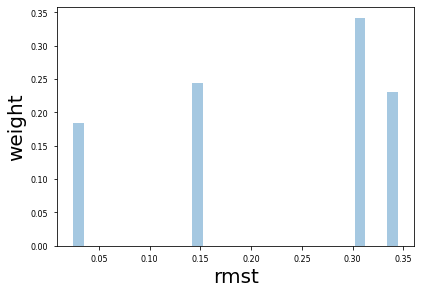

In [35]:

fig, ax = plt.subplots(1,1)
path = base_path+'figures/misc/'
Path(path).mkdir(exist_ok = True)
ax = sns.distplot(rmst_pd['RMST-18-Months'].values, hist_kws = {'weights':rmst_pd['Weight'].values} , bins=30, kde = False,ax = ax)
ax.set_xlabel('rmst')
ax.set_ylabel('weight')
fig.savefig(path+'hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

In [26]:
from sklearn.cluster import KMeans as KM

In [36]:
cl = 2
model5  = KM(n_clusters = cl)
model5 = model5.fit(X = rmst_pd['RMST-18-Months'].values.reshape(-1,1), sample_weight = rmst_pd['Weight'].values)
labels = model5.predict(X = rmst_pd['RMST-18-Months'].values.reshape(-1,1))
rmst_pd['Labels'] =  (rmst_pd['RMST-18-Months']>0.2).astype(int)
rmst_pd.sort_values(by = ['Labels', 'RMST-18-Months'])

C  RMST-6-Months  RMST-12-Months  RMST-18-Months  RMST-24-Months  Size  \
2  2       0.011952        0.012588        0.024650        0.055115   251   
3  3      -0.015663        0.054367        0.151219        0.359005   332   
0  0       0.040343        0.098130        0.307611        0.484395   466   
1  1      -0.001905        0.119230        0.344607        0.626381   315   

     Weight  Labels  
2  0.184018       0  
3  0.243402       0  
0  0.341642       1  
1  0.230938       1

filt = rmst_pd['Labels'] == 0
g0 = rmst_pd[filt].C
g1 = rmst_pd[~filt].C

tr1 = pd.DataFrame()
tr0 = pd.DataFrame()
cr1 = pd.DataFrame()
cr0 = pd.DataFrame()

for g in g0:
    tr0 = pd.concat((tr0, treated_groups[g]), ignore_index = True)
    cr0 = pd.concat((cr0, control_groups[g]), ignore_index = True)  
    
for g in g1:
    tr1 = pd.concat((tr1, treated_groups[g]), ignore_index = True)
    cr1 = pd.concat((cr1, control_groups[g]), ignore_index = True) 

### Reassemble Groups

In [37]:

filts = [rmst_pd['Labels'] == i for i in range(cl)]
dfsTr = [pd.DataFrame() for i in range(cl)]
dfsCo = [pd.DataFrame() for i in range(cl)]
assigned_groups = [rmst_pd[f].C.values for f in filts]

In [38]:
for i, ag in enumerate(assigned_groups):
    for g in ag:
        dfsTr[i] = pd.concat((dfsTr[i], treated_groups[g]), ignore_index = True)
        dfsCo[i] = pd.concat((dfsCo[i], control_groups[g]), ignore_index = True) 

In [39]:
rmsts_final = {}
lgs_final = {}
stats_final = {}
surv_final = {}

### Diff and Diff for reconstructed 

(12554, 101) (60193, 104)
(583,) (2915,)
(583,) (2915,)
(16589, 101) (78147, 104)
(781,) (3905,)
(781,) (3905,)


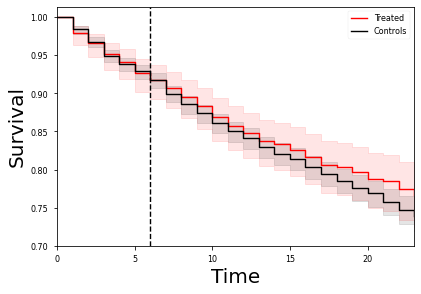

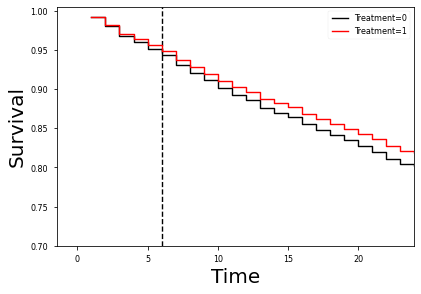

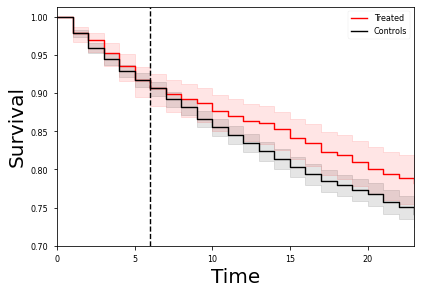

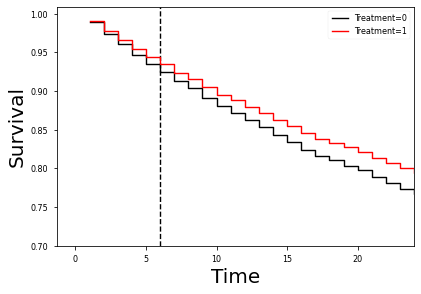

In [40]:
for i, (treatedi, controlsi) in enumerate(zip(dfsTr, dfsCo)):
    r,l,st,surv = diff(treatedi, controlsi,controls2, pmpm.copy(), group_name = 'g'+str(i), pf = 'reconstruction/')
    rmsts_final[i] = r
    lgs_final[i] = l
    stats_final[i] = st
    surv_final[i] = surv

### SAVE lOG-RANKS P-VALUES

In [41]:
lranks_pdf = pd.DataFrame()
for g in lgs_final:
    lranks_pdf = pd.concat((lranks_pdf, lgs_final[g]), axis = 0, ignore_index = True)

rmst_pdf = pd.DataFrame(rmsts_final, index = ['RMST-'+str(i)+'-Months' for i in [6,12,18,24]]).T
rmst_pdf.index.name = 'C'
rmst_pdf = rmst_pdf.reset_index()
lr_rmsf = pd.concat((lranks_pdf, rmst_pdf), axis = 1)
lr_rmsf.to_csv(path_tabs+'reconstruction/Acute-Care_ddlrank_rmst.csv')

_,_, stats0,surv0 = diff(tr0, cr0, controls2.copy(), pmpm.copy(),group_name = 'g0', pf = 'reconstruction/')

_,_, stats1,surv1 = diff(tr1, cr1, controls2.copy(), pmpm.copy(), group_name = 'g1', pf = 'reconstruction/')

### save stats arrays

In [42]:
from diabetes_onset_plotter import save_arrays2

for g, lst in stats_final.items():
    names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols']
    save_arrays2(lst, names, base_path+'tables/stats/reconstruction/group'+str(g)+'/')

%%time
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']
                   
tr_desc0, treated_first_month = statistics_first_month(tr0, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(cr0, all_columns, return_array = True)
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, tr_desc0, con_desc0, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, tr_desc0, con_desc0, columns = all_columns)

In [43]:
for g, lst in stats_final.items():
    display(lst[0])

Treated Matched Controls   Test-TC            \
                       mean             mean    t-stat      pval   
AGE_AT_MIDMONTH   49.564322        49.621612 -0.096659  0.923003   
ALLOW_AMT        645.639794       612.411664  0.421690  0.673277   
MBR_GNDR           0.430532         0.430532  0.000000  1.000000   
CC_TOBACCO         0.000000         0.009949 -2.419697  0.015584   
CC_PRESSURE        0.003431         0.001029  1.400994  0.161305   
CC_OBESITY         0.758148         0.736535  1.086092  0.277513   
CC_HYPERTENSION    0.198971         0.209605 -0.577561  0.563598   
CC_HYPOTHYROID     0.000000         0.006861 -2.006323  0.044899   
CC_DX_CNT          2.902230         2.865180  0.421044  0.673749   
ACUTE2             0.029160         0.024014  0.711572  0.476778   
ACUTE6             0.092624         0.091938  0.045728  0.963529   
IP_BIN6            0.024014         0.024014  0.000000  1.000000   
ER_BIN6            0.070326         0.069983  0.026444  0.978905   
LOB                0.945111         0.945111  0.000000  1.000000   
Acute6-bin         0.082333         0.082333  0.000000  1.000000   

                General Population      Random  
                              mean        mean  
AGE_AT_MIDMONTH          49.564322   49.621612  
ALLOW_AMT               645.639794  612.411664  
MBR_GNDR                  0.430532    0.430532  
CC_TOBACCO                0.000000    0.009949  
CC_PRESSURE               0.003431    0.001029  
CC_OBESITY                0.758148    0.736535  
CC_HYPERTENSION           0.198971    0.209605  
CC_HYPOTHYROID            0.000000    0.006861  
CC_DX_CNT                 2.902230    2.865180  
ACUTE2                    0.029160    0.024014  
ACUTE6                    0.092624    0.091938  
IP_BIN6                   0.024014    0.024014  
ER_BIN6                   0.070326    0.069983  
LOB                       0.945111    0.945111  
Acute6-bin                0.082333    0.082333

Treated Matched Controls   Test-TC            \
                       mean             mean    t-stat      pval   
AGE_AT_MIDMONTH   51.672215        51.746223 -0.157261  0.875046   
ALLOW_AMT        750.668374       656.754673  0.860604  0.389500   
MBR_GNDR           0.048656         0.048656  0.000000  1.000000   
CC_TOBACCO         0.103713         0.085787  1.607980  0.107907   
CC_PRESSURE        0.000000         0.000512 -0.632483  0.527102   
CC_OBESITY         0.304738         0.303969  0.042595  0.966026   
CC_HYPERTENSION    0.449424         0.418950  1.573203  0.115739   
CC_HYPOTHYROID     0.176697         0.142382  2.465670  0.013711   
CC_DX_CNT          2.895006         2.872471  0.246175  0.805557   
ACUTE2             0.043534         0.038156  0.657662  0.510788   
ACUTE6             0.119078         0.118822  0.015607  0.987549   
IP_BIN6            0.024328         0.024328  0.000000  1.000000   
ER_BIN6            0.101152         0.099360  0.119807  0.904641   
LOB                0.965429         0.965429  0.000000  1.000000   
Acute6-bin         0.093470         0.093470  0.000000  1.000000   

                General Population      Random  
                              mean        mean  
AGE_AT_MIDMONTH          51.672215   51.746223  
ALLOW_AMT               750.668374  656.754673  
MBR_GNDR                  0.048656    0.048656  
CC_TOBACCO                0.103713    0.085787  
CC_PRESSURE               0.000000    0.000512  
CC_OBESITY                0.304738    0.303969  
CC_HYPERTENSION           0.449424    0.418950  
CC_HYPOTHYROID            0.176697    0.142382  
CC_DX_CNT                 2.895006    2.872471  
ACUTE2                    0.043534    0.038156  
ACUTE6                    0.119078    0.118822  
IP_BIN6                   0.024328    0.024328  
ER_BIN6                   0.101152    0.099360  
LOB                       0.965429    0.965429  
Acute6-bin                0.093470    0.093470